In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "C:\Users\Pascal\Anaconda3\envs\deep_learning_gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\Pascal\Anaconda3\envs\deep_learning_gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\Pascal\Anaconda3\envs\deep_learning_gpu\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\Pascal\Anaconda3\envs\deep_learning_gpu\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "C:\Users\Pascal\Anaconda3\envs\deep_learning_gpu\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
import keras
from keras import backend as K
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input,Activation, concatenate, Embedding, Reshape
from keras.layers import Flatten, merge, Lambda, Dropout, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.models import model_from_json
from keras.models import load_model
from keras.regularizers import l1,l2
import tensorflow as tf
import gc

Using TensorFlow backend.


In [24]:
#df = pd.read_csv('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/data_final.csv', index_col=[0])
#df = pd.read_csv('/Users/BharathiSrinivasan/Documents/GitHub/Thesis/merged_data.csv')
folder = 'C:\\Users\\Pascal\\Documents\\GitHub\\instacart-market-basket-analysis\\'

#df_big = pd.read_csv(folder + 'merged_data.csv')
#df_use = pd.read_csv(folder + 'engineered_data_10000.csv')
df_use = pd.read_csv(folder + 'data1000.csv')

In [25]:
df_use.fillna(0,inplace = True)

In [26]:
df_use.drop_duplicates(inplace=True)

In [27]:
df_use.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,202279,3,5,9,8.0,Michigan Organic Kale,83,4,produce
2,2,9327,3,0,202279,3,5,9,8.0,Garlic Powder,104,13,pantry
3,2,45918,4,1,202279,3,5,9,8.0,Coconut Butter,19,13,pantry
4,2,30035,5,0,202279,3,5,9,8.0,Natural Sweetener,17,13,pantry


In [28]:
# Number of product IDs available
N_products = df_use['product_id'].nunique()
N_shoppers = df_use['user_id'].nunique()

In [29]:
print('Unique Products:', N_products)
print('Unique_Users: ', N_shoppers)

Unique Products: 19039
Unique_Users:  1000


In [30]:
# load embeddings model
json_file = open('NN_embed_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("NN_embed_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [31]:
# Exctracted embeddings from pr-trained model
embeddings_prior = loaded_model.layers[2].get_weights()[0]
embeddings_user = loaded_model.layers[3].get_weights()[0]

In [32]:
embeddings_user.shape

(1001, 10)

In [33]:
def val2idx(df, cols):
    """
    Helper to index values of embedding columns
    """
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()

    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x]+1)

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals

In [34]:
EMBEDDING_COLUMNS = ["user_id", "product_id"]
df_deep, values = val2idx(df_use, EMBEDDING_COLUMNS)

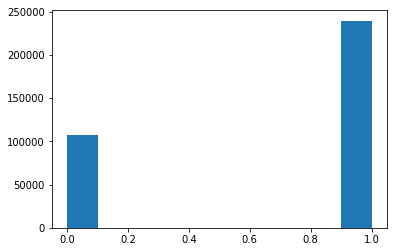

In [35]:
plt.figure()
plt.hist(df_deep.reordered)
plt.show()

In [36]:
df_deep.drop(['product_name','department'], axis=1, inplace=True)

In [37]:
CATEGORICAL_COLUMNS = ["order_dow", "order_hour_of_day","aisle_id","department_id"]
CONTINUOUS_COLUMNS = ["days_since_prior_order","order_number","add_to_cart_order" ]

In [38]:
#import seaborn as sns
#sns.heatmap(df_small.corr(),cmap="YlGnBu")

In [39]:
#One-hot encoding categorical columns
df_small = pd.get_dummies(df_use, columns=[x for x in CATEGORICAL_COLUMNS])

In [40]:
#Normalising the feature columns
df_small[CONTINUOUS_COLUMNS] = MinMaxScaler().fit_transform(df_small[CONTINUOUS_COLUMNS].values)

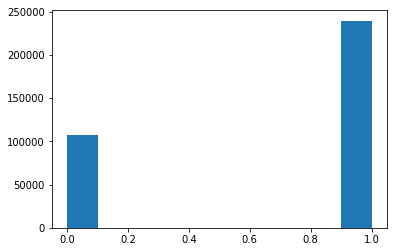

In [41]:
plt.figure()
plt.hist(df_small.reordered)
plt.show()

In [42]:
y = df_small.reordered.values

In [43]:
df_small.drop(['reordered'], axis=1, inplace = True)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_small, y, test_size=0.20, random_state=42, stratify=y)

In [45]:
products_in = X_train['product_id']
X_train.drop(['product_id'], axis = 1, inplace=True)

products_test = X_test['product_id']
X_test.drop(['product_id'], axis = 1, inplace=True)

C:\Users\Pascal\Anaconda3\envs\Deep_Learning\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [46]:
users_in = X_train['user_id']
X_train.drop(['user_id'], axis=1, inplace= True)

users_test = X_test['user_id']
X_test.drop(['user_id'], axis=1, inplace= True)

In [47]:
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

In [48]:

# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

# Embeddings
prior = Embedding(input_dim=embeddings_prior.shape[0], input_length=1,weights=[embeddings_prior], output_dim=embeddings_prior.shape[1], trainable=False)(prior_in)
shopper = Embedding(input_dim=embeddings_user.shape[0], input_length=1,weights=[embeddings_user], output_dim=embeddings_prior.shape[1], trainable=False)(shopper_in)

# Numeric and categorical inputs
input_tensor = Input(shape=X_train.shape[1:])

reshape = Reshape(target_shape=(10,))

combined_input = keras.layers.concatenate([reshape(prior), reshape(shopper), input_tensor])

x = BatchNormalization()(combined_input)

# Replace Dropout with PermaDropout for MC Dropout
#x = PermaDropout(0.4)(x)

#x = Dropout(0.5)(x, training=True)
x = Dense(256, activation='softplus')(x)
x = BatchNormalization()(x)

#x = PermaDropout(0.4)(x)
#x = Dropout(0.5)(x, training=True)
x = Dense(128, activation='softplus')(x)
x = BatchNormalization()(x)

logits = Dense(1,activation='softplus')(x)
#variance_pre = Dense(1)(x)
#variance = Activation('softplus', name='variance')(variance_pre)
#logits_variance = concatenate([logits, variance], name='logits_variance')
softmax_output = Activation('sigmoid', name='logit_output')(logits)

model = Model(inputs=[prior_in, shopper_in, input_tensor], outputs=softmax_output)

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        190400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        10010       input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [50]:
model.compile(optimizer='adam', \
              loss='binary_crossentropy',\
              metrics=['accuracy'] )

In [51]:
history = model.fit([products_in, users_in, X_train],y_train, batch_size = 100, epochs = 5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
277101/277101 [==============================] - 14s 50us/step - loss: nan - acc: 0.0000e+00
Epoch 2/5
277101/277101 [==============================] - 13s 47us/step - loss: nan - acc: 0.0000e+00
Epoch 3/5
277101/277101 [==============================] - 14s 49us/step - loss: nan - acc: 0.0000e+00
Epoch 4/5
277101/277101 [==============================] - 14s 49us/step - loss: nan - acc: 0.0000e+00
Epoch 5/5
277101/277101 [==============================] - 14s 49us/step - loss: nan - acc: 0.0000e+00


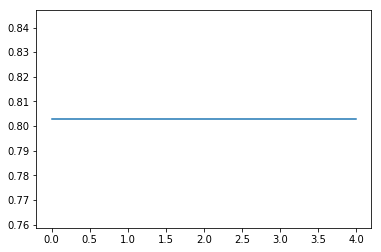

In [95]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [96]:
logit_model = Model(inputs=[prior_in, shopper_in, input_tensor], outputs=logits)
logit_output = logit_model.predict([products_test, users_test, X_test],verbose=0)

In [97]:
score = model.evaluate([products_test, users_test, X_test], y_test, verbose=1)
print('Test accuracy:', score[1])

18/18 [==============================] - 0s 16ms/step
Test accuracy: 0.7777777910232544


In [98]:
print(score)

[0.5766987800598145, 0.7777777910232544]


In [56]:
def MCdropout(T=1000):
    
    Yt_hat = []
    for _ in range(T):
        Yt_hat += [model.predict([products_test, users_test, X_test],verbose=0)]
    # 100 arrays with one output of each observation for X_test
    Yt_hat = np.array(Yt_hat)
    
    predictive_mean = np.mean(Yt_hat, axis=0)
    epistemic = np.mean(Yt_hat ** 2, axis=0) - np.mean(Yt_hat, axis=0) ** 2
    epistemic = np.sum(epistemic)
    aleatoric = np.mean(Yt_hat * (1-Yt_hat), axis = 0)
    aleatoric = np.sum(aleatoric)
    
    return Yt_hat, predictive_mean, epistemic, aleatoric

In [57]:
probs, predictive_mean, model_uncertainty, data_uncertainty = MCdropout(T=1000)

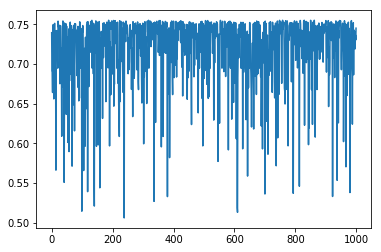

In [69]:
plt.figure()
plt.plot(probs[:,1].reshape(-1))
plt.show()

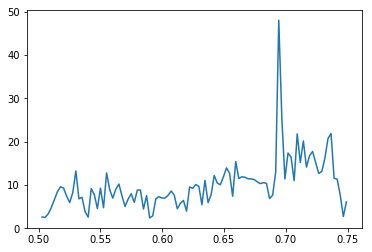

In [77]:
from scipy.interpolate import UnivariateSpline
N = 1000
n = N//10
x1=probs[:,10].reshape(-1)

p, x = np.histogram(x1, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()

In [82]:
percentile_probs = np.percentile(probs, 20, axis=0)

In [ ]:
def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions))/N
    return ce

In [90]:
from sklearn.metrics import accuracy_score, log_loss
http://blog.s-schoener.com/2017-12-20-uncertainty-in-dl/

logloss_score1 = log_loss(y_test,percentile_probs)
acc1 = accuracy_score(y_test, np.round(percentile_probs))
print('With percentile_preds: ',logloss_score1, acc1)

With predictive_mean:  0.5447861270772086 0.7777777777777778
With percentile_preds:  0.5671818096916228 0.7777777777777778


In [61]:
# Testing dropout model accuracy
from sklearn.metrics import accuracy_score
#print('Accuracy :', accuracy_score(y_test, predictive_mean))
print('Epistemic Uncertainty : ', model_uncertainty)
print('Aleatoric Uncertainty : ', data_uncertainty)

Epistemic Uncertainty :  0.0847342
Aleatoric Uncertainty :  3.8486407
Total Uncertainty :  0.08472934


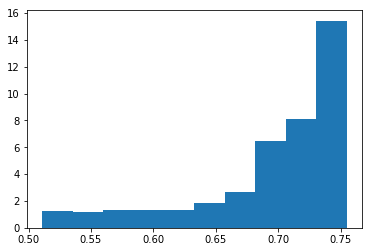

In [76]:
#Stacked bar histogram of output probabilities
plt.figure()
x1=probs[:,1].reshape(-1)
x2 = probs[:,2].reshape(-1)
x3 = probs[:,3].reshape(-1)
plt.hist(x3,normed=True)
plt.show()

In [89]:
Yt_hat[1].reshape(-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))